In [1]:
import pandas as pd
import json
import os
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

root_file = './data/CLEAN_DB_FOR_GNN_17_02/'
train = pd.read_csv(os.path.join(root_file, 'train.txt'), header=None, names=['h', 'r', 't'])
test = pd.read_csv(os.path.join(root_file, 'test.txt'), header=None, names=['h', 'r', 't'])
map_ = pd.read_csv(os.path.join(root_file, 'DB_Bert_Emb_INT__MAPPING.csv'))
db2index = dict(zip(map_.DB_ID, map_.INDEX))
index2db = dict(zip(map_.INDEX, map_.DB_ID))
emb_ = pd.read_csv(os.path.join(root_file, 'DB_Bert_Emb_INT.csv'))
mapping = {}
for i, row in emb_.iterrows():
    mapping[row['DB_ID']] = row[:-1].values
db_ids = db2index.keys()
assert len(set(index2db.keys()).difference(train['h'].unique().tolist()+train['t'].unique().tolist()+test['h'].unique().tolist()+test['t'].unique().tolist())) == 0

In [2]:
print("UNIQUE NODES: %d" % (len(db2index)))

UNIQUE NODES: 1476


In [26]:
import networkx as nx
g = nx.Graph()
for i in index2db:
    g.add_node(i)
g.add_edges_from(list(zip(train.h, train.t)))

adj_pred = np.zeros((len(db2index), len(db2index)))
for sc in tqdm_notebook(nx.resource_allocation_index(g, [(i,j) for i in range(len(db2index)) for j in range(len(db2index))])):
    adj_pred[sc[0], sc[1]] = sc[2]

/media/kostas/DATA/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

In [16]:
pairs = train['h'].astype(str) + '_' + train['t'].astype(str)
x_train_pairs = list(set(pairs))
print(len(pairs), len(x_train_pairs))

pairs = test['h'].astype(str) + '_' + test['t'].astype(str)
x_test_pairs = list(set(pairs))
print(len(pairs), len(x_test_pairs))


import numpy as np
def get_sparsity(A):
    return 1.0 - ( np.count_nonzero(A) / float(A.size) )

# Adj matrix (train)

adj_train = np.zeros((len(db_ids), len(db_ids)), dtype=np.int8)
for item in x_train_pairs:
    splits = item.split("_")
    try:
        adj_train[int(splits[0]), int(splits[1])] = 1
    except KeyError:
        continue
        
        
print("Sparsity Train: %0.2f%%"%(100*get_sparsity(adj_train)))

adj_test = np.zeros((len(db_ids), len(db_ids)), dtype=np.int8)
for item in x_test_pairs:
    splits = item.split("_")
    try:
        adj_test[int(splits[0]), int(splits[1])] = 1
    except KeyError:
        continue

print("Sparsity Test: %0.2f%%"%(100*get_sparsity(adj_test)))

adj_all = np.zeros_like(adj_train, dtype=np.int8)
adj_all = adj_train + adj_test
adj_all = np.clip(adj_all, 0, 1)
print("Sparsity Total: %0.2f%%"%(100*get_sparsity(adj_all)))

In [18]:
def show_metrics_pos(y_true, y_score, wanted_indexes=None, print_=True, neg_label=0, pos_label=1):
    if wanted_indexes:
        y_true = y_true[wanted_indexes]
        y_score = y_score[wanted_indexes]
    if neg_label != 0:
        y_true[y_true==neg_label] = 0
        y_score[y_score==neg_label] = 0
    if pos_label != 1:
        y_true[y_true==pos_label] = 1
        y_score[y_score==pos_label] = 1
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # False negative
    fn = np.sum(y_true * (y_score==0))
    # tn
    tn = np.sum((y_true == 0) * (y_score==0))
    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # Precision
    precision = tp / (tp + fp)
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
#     print("True positive: ", tp)
#     print("False positive: ", fp)
#     print("False negative: ", fn)
    if print_:
        print("True positive: ", tp)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True negative: ", tn)
        print("Total #: ", tp + fp +fn +tn)
        print("True positive rate (recall): ", tpr)
        print("Precision: ", precision)
        print("F1: ", f1)
    return precision, tpr, f1

In [19]:
import numpy as np
thresholds = np.linspace(np.min(adj_pred), np.max(adj_pred), 100)
fs = []
#adj_pred.fill_diagonal(np.max(adj_pred))
for tr in tqdm_notebook(thresholds):
    cur_ = adj_pred.copy()
    cur_ = (cur_ > tr).astype(np.int_)
    #cur_[cur_>= tr] = 0
    #cur_[cur_< tr] = 1
    #print(tr)
    #print(cur_.sum())
    _, _, f = show_metrics_pos(adj_train.ravel(), adj_pred.ravel(), print_=False)
    fs.append(f)
    
tr = thresholds[np.argmax(fs)]
plt.figure(figsize=(8, 8))
plt.plot(thresholds, fs, "r-", label="F1")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best')
plt.title("With threshold %0.2f that gives %0.2f F1 at train edges." % (tr, np.max(fs)))


# Binarize
cur_ = adj_pred.copy().reshape(adj_test.shape)
#np.fill_diagonal(cur_, np.max(cur_))
cur_ = (cur_ > tr).astype(np.int_)
_, _, _ = show_metrics_pos(adj_test.ravel(), cur_.ravel())

/media/kostas/DATA/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/media/kostas/DATA/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5,1,'With threshold 4.33 that gives 0.66 F1 at train edges.')

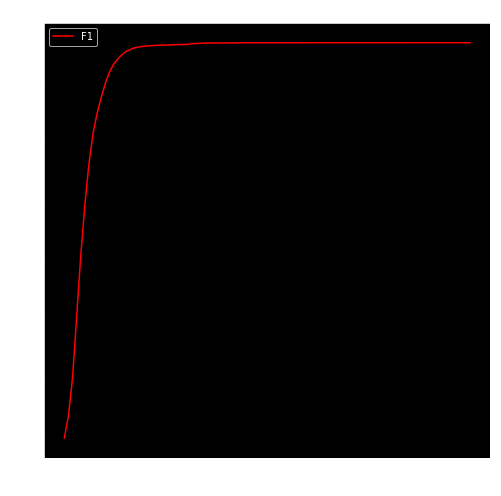